In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

torch.__version__

/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1'

## PyTorch Fashion MNIST Classification

### Getting dataset

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True, # download images
    transform=ToTensor(), #transform the data
    target_transform=None # transform the labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Visualzing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

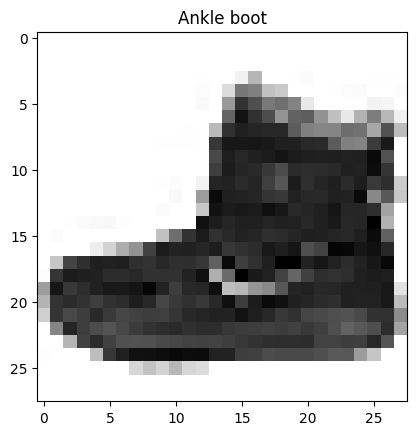

In [7]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow( image.permute(1, 2, 0), cmap='binary' )
plt.title(class_names[label])

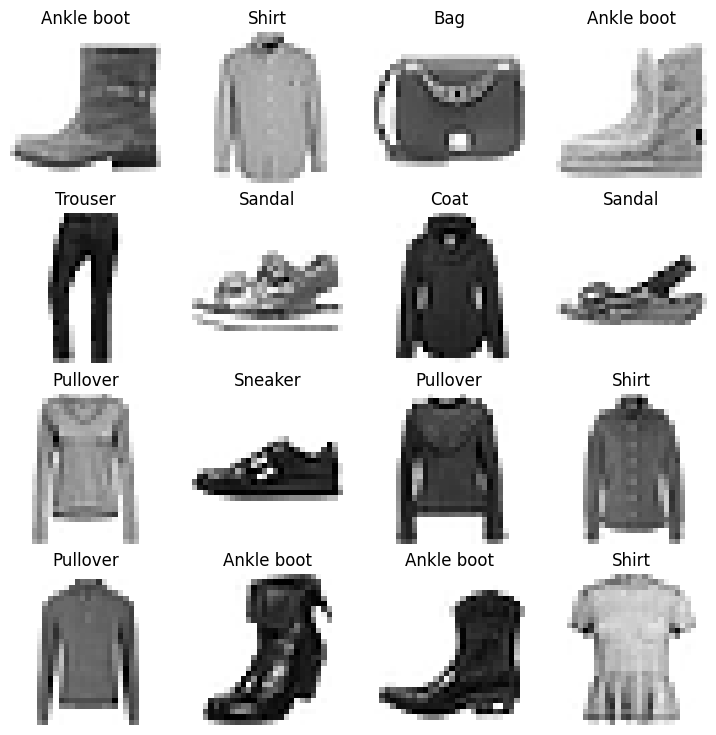

In [8]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0), cmap='binary')
    plt.title(class_names[label])
    plt.axis(False)

### Prepare DataLoader

In [9]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

#Turn datasets into a iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7efe663234f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7efe66323f70>)

In [11]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7efe663234f0>, <torch.utils.data.dataloader.DataLoader object at 0x7efe66323f70>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [12]:
#Last batch is not size of 32
10000 / 32

312.5

### Checking out images from training dataloader

In [13]:
train_features_batch, train_labels_batch = next( iter(train_dataloader) )
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


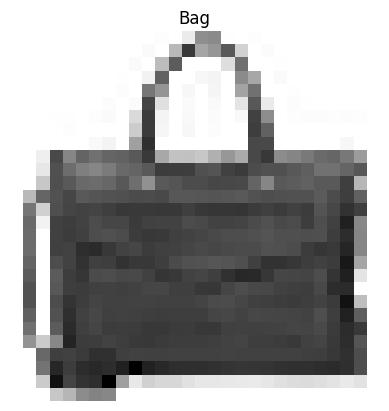

In [14]:
# Show a sample
# torch.manual_seed(42)
#Pick a random shirt from the batch size
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='binary')
plt.title(class_names[label])
plt.axis(False)

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### Building a baseline model

In [15]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a simple sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [16]:
class FashionMNISTModelV0(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x).shape

torch.Size([1, 10])

### Setup loss, optimizer and evaluation metrics



In [19]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

train_accuracy = Accuracy('multiclass', num_classes=10)
train_accuracy = Accuracy('multiclass', num_classes=10)

### Creating a function to time our experiments
Machine Learning is very experimental

Two main things we need to track is 
1. Model performance
2. How fast it runs

In [20]:
from timeit import default_timer as timer 

def print_train_time(start, end, device=None):
    total_time = end - start 

    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [21]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 seconds


1.953699938894715e-05

### Creating a training loop on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. Print out what's happening
5. Time it all (for fun)

In [22]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [23]:
!pip install tqdm -q

In [24]:
#Fancy progress bar
from tqdm.auto import tqdm

# set seed and start timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

#Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    ### Training
    train_loss = 0
    # add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        optimizer.zero_grad()

        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumulate train loss

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

            #1. Forward pass
            test_pred = model_0(X_test)

            #2. Calculate loss
            test_loss += loss_fn(test_pred, y_test)

            #3. calculate accuracy
            #you can also use logits instead of passing it through the final activation function.
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        #Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

#Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 33%|███▎      | 1/3 [00:08<00:17,  8.79s/it]


Train loss: 1.9379 | Test loss: 1.5435, Test acc: 62.4201
Epoch: 1
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 67%|██████▋   | 2/3 [00:17<00:08,  8.52s/it]


Train loss: 1.2492 | Test loss: 1.0609, Test acc: 66.1542
Epoch: 2
------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


100%|██████████| 3/3 [00:25<00:00,  8.43s/it]


Train loss: 0.9507 | Test loss: 0.8914, Test acc: 69.9980
Train time on cpu: 25.306 seconds


### Make prediction and get Model 0 results


In [25]:
torch.manual_seed(42)

def eval_model(model, data_loader, loss_fn, accuracy_fn):
    """
    Returns a dictionary containing the results of model predicting on data_loader
    """
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            y_pred = model(X)

            #Accumlate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {'model_name': model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0, 
                             data_loader=test_dataloader,
                              loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 320.44it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.8913663625717163,
 'model_acc': 69.99800319488818}

### Setup and Using GPU

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Building a new model with non-linearity

In [27]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            # nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [28]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

### Setup loss, optimizer and evaluation metrics

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

### Functionizing training and evaluation/testing loops 

In [30]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               accuracy_fn, 
               device: torch.device=device):
     ### Training
    train_loss, train_acc = 0, 0


    # add a loop to loop through the training batches
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumulate train loss

        # acc
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss.backward()

        optimizer.step()

        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader
    train_loss /= len(data_loader)

    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")


In [31]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X) # outputs raw logits

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [32]:
torch.manual_seed(42)

from timeit import default_timer as timer 
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)

    test_step(model=model_1, accuracy_fn=accuracy_fn, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 2.12671 | Train acc: 21.52


 33%|███▎      | 1/3 [00:11<00:23, 11.59s/it]

Test loss: 1.92356 | Test acc: 32.24%
Epoch: 1
------
Train loss: 1.66095 | Train acc: 53.13


 67%|██████▋   | 2/3 [00:23<00:11, 11.58s/it]

Test loss: 1.40388 | Test acc: 63.28%
Epoch: 2
------
Train loss: 1.19357 | Train acc: 65.09


100%|██████████| 3/3 [00:34<00:00, 11.58s/it]

Test loss: 1.05513 | Test acc: 65.37%
Train time on cuda: 34.735 seconds


In [33]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.8913663625717163,
 'model_acc': 69.99800319488818}

In [34]:
total_train_time_model_0

25.305661513000814

In [35]:
model_1_results = eval_model(model=model_1.to('cpu'),
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 314.43it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 1.0551300048828125,
 'model_acc': 65.36541533546325}

### Model 2: CNN Model

In [64]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Using TinyVGG
    """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        
        return x

In [65]:
image.shape

torch.Size([1, 28, 28])

In [66]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # number of channels 
                              hidden_units=10,
                              output_shape=len(class_names)
                              ).to(device)

### Testing if model_2 works

THe errors can be used to find the hidden units of the linear layer input

In [67]:
rand_image_tensor = torch.randn(size=(1, 1, 28, 28), device=device)

with torch.inference_mode():
    tmp = model_2(rand_image_tensor)

### Stepping through `nn.Conv2d` layer

In [68]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"SIngle Image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
SIngle Image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [69]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                        out_channels=10,
                        kernel_size=3, 
                        stride=1,
                        padding=1,
                        )

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

### Stepping through `nn.MaxPool2d()`

In [70]:
# print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d 
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through convlayer: {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([10, 64, 64])
Shape after going through convlayer: torch.Size([10, 32, 32])


In [71]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"\nRandom Tensor:\n {random_tensor}")
print(f"\nRandom Tensor Shape:\n {random_tensor.shape}")


#Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

#Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random Tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

Random Tensor Shape:
 torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### Setup a loss function and optimizer

In [72]:
# Setup loss function/eval metrics/optiizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [73]:
next(model_2.parameters()).device

device(type='cuda', index=0)

### Training and testing `model_2` using training and test function

In [74]:
torch.manual_seed(32)
torch.cuda.manual_seed(32)

from timeit import default_timer as timer 

train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"EPoch: {epoch}\n----")
    train_step(model=model_2, 
               data_loader=train_dataloader, 
               loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device,
                optimizer=optimizer)
    
    test_step(model=model_2, device=device, accuracy_fn=accuracy_fn, data_loader=test_dataloader, loss_fn=loss_fn)


train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

EPoch: 0
----
Train loss: 2.29637 | Train acc: 10.44


 33%|███▎      | 1/3 [00:15<00:31, 15.83s/it]

Test loss: 2.28267 | Test acc: 12.77%
EPoch: 1
----
Train loss: 1.77709 | Train acc: 40.06


 67%|██████▋   | 2/3 [00:31<00:15, 15.61s/it]

Test loss: 0.95619 | Test acc: 62.27%
EPoch: 2
----
Train loss: 0.80089 | Train acc: 70.23


100%|██████████| 3/3 [00:46<00:00, 15.51s/it]

Test loss: 0.75925 | Test acc: 72.73%
Train time on cuda: 46.529 seconds


In [77]:
model_2_results = eval_model(
    model=model_2.to('cpu'),
    accuracy_fn=accuracy_fn,
    data_loader=test_dataloader,
    loss_fn=loss_fn
)
model_2_results

100%|██████████| 313/313 [00:01<00:00, 182.05it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.7592507004737854,
 'model_acc': 72.73362619808307}

In [78]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.8913663625717163,
 'model_acc': 69.99800319488818}

### Compare model results and training time

In [79]:
import pandas as pd 
compare_results = pd.DataFrame([
    model_0_results,
    model_1_results,
    model_2_results
])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.891366,69.998003
1,FashionMNISTModelV1,1.055130,65.365415
2,FashionMNISTModelV2,0.759251,72.733626


In [80]:
# Adding training time to results comparison
compare_results['training_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.891366,69.998003,25.305662
1,FashionMNISTModelV1,1.055130,65.365415,34.735369
2,FashionMNISTModelV2,0.759251,72.733626,46.529320


Text(0, 0.5, 'model')

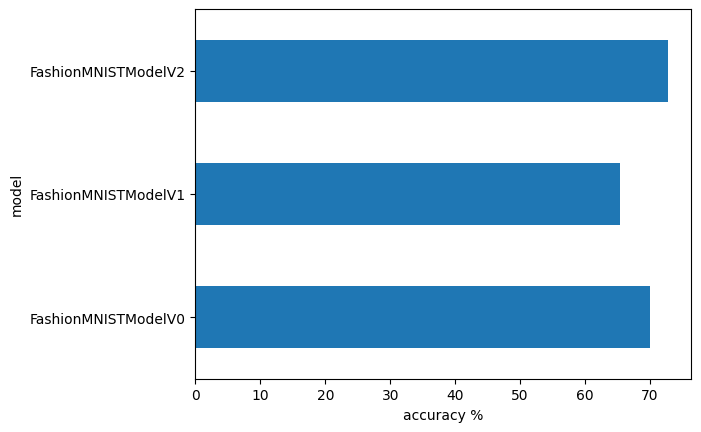

In [81]:
# Visualise our model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy %')
plt.ylabel('model')

### 9. Make and evaluate random predictions with best model

In [103]:
def make_predictions(model, data, device,):
    pred_probs = []

    model = model.to(device)
    
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample, (adds a batch dimention and pass to the target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            #Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get predictions probability (logits -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calcuation
            pred_probs.append(pred_prob.cpu())

        # Stack the pred_provs to turn list into a tensor
        return torch.stack(pred_probs)

In [104]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [105]:
import random 
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

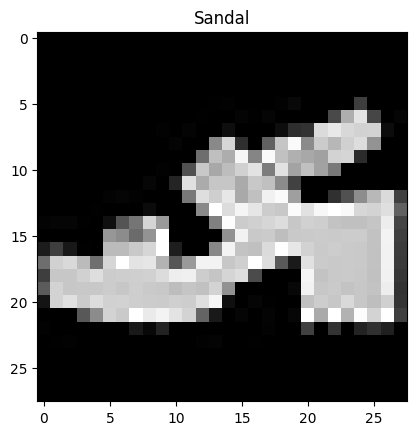

In [106]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

In [108]:
# Make predictions
pred_probs = make_predictions(model=model_2, data=test_samples, device=device)

pred_probs[:2]

tensor([[2.5007e-08, 2.3395e-10, 4.2483e-06, 7.3690e-08, 3.1918e-05, 6.1795e-01,
         1.2194e-06, 9.4805e-02, 4.6503e-03, 2.8256e-01],
        [6.2992e-02, 6.8199e-01, 1.8228e-03, 1.9344e-01, 5.4870e-02, 6.1429e-08,
         4.8547e-03, 5.8682e-07, 2.3345e-05, 3.0073e-06]])

In [109]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

(-0.5, 27.5, 27.5, -0.5)

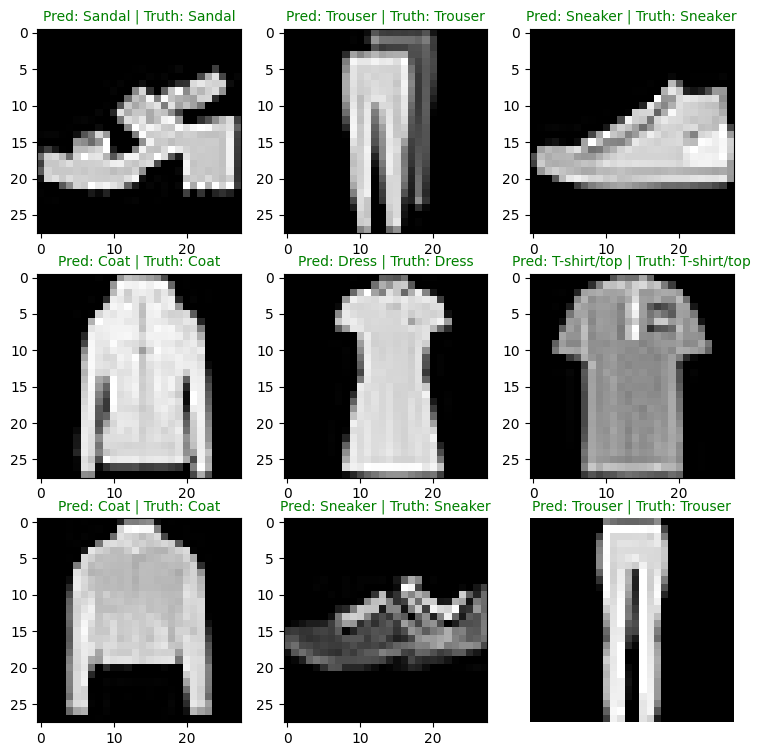

In [114]:
# Plot predictions
plt.figure(figsize=(9,9))

n_rows = 3
n_cols = 3

for i, sample in enumerate(test_samples):
    #Create subplot 
    plt.subplot(n_rows, n_cols, i+1)

    # plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')

    #Find the prediction (in text form)
    pred_label = class_names[pred_classes[i]]

    #get the truth label
    truth_label = class_names[test_labels[i]]

    #Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c="r")

plt.axis(False)

### Making a confusion matrix for further prediction evaluation


1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.COnfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [117]:
from tqdm.auto import tqdm

# make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)

        y_logit = model_2(X)

        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

        y_preds.append(y_pred.cpu())

# print(y_preds)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 175.83it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 4, 5, 7])

In [118]:
len(y_pred_tensor)

10000

In [120]:
!pip install mlxtend -q


In [122]:
import torchmetrics, mlxtend

mlxtend.__version__

'0.21.0'

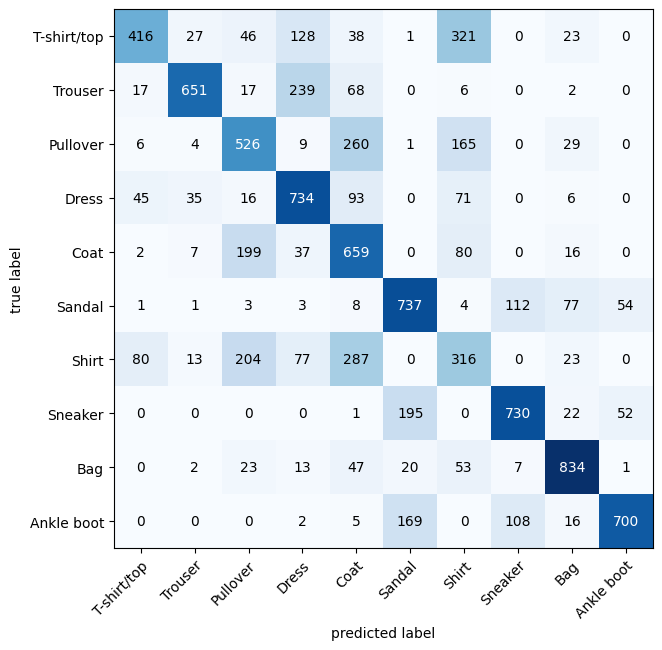

In [124]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#Compute confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

#plotting
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

### Save and load best performing labels

In [126]:
from pathlib import Path

# Create a model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = '03_pytorch_computer_vision_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving state dict
print(f"SAving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

SAving model to : models/03_pytorch_computer_vision_model.pth


In [127]:
# Loading model
loaded_model = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))

#LOad in the save state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [128]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.7592507004737854,
 'model_acc': 72.73362619808307}

In [130]:
#Evaluate loaded model
torch.manual_seed(42)
loaded_model_results = eval_model(model=loaded_model.to('cpu'), data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
loaded_model_results

100%|██████████| 313/313 [00:01<00:00, 178.27it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.7592507004737854,
 'model_acc': 72.73362619808307}